Now, lets use our model to predcit the NEPSE Closing price upto Februray 28 (our data is upto Feb 15) to see how it performs<br>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

First, we load the original dataset

In [2]:
df = pd.read_csv('../data/nepse_data.csv')

In [3]:
df.head()

,S.N.,Open,High,Low,Close,Change,Per Change(%),Turnover,Date
0,1,"2,075.62","2,076.84","2,055.82","2,062.03",-14.46,-0.69,"3,869,118,741.97",2024-02-15
1,2,"2,071.71","2,081.56","2,064.85","2,076.50",5.91,0.28,"4,252,722,895.25",2024-02-14
2,3,"2,101.54","2,101.54","2,065.14","2,070.59",-30.56,-1.45,"4,667,179,304.13",2024-02-13
3,4,"2,085.81","2,103.56","2,081.99","2,101.16",15.33,0.73,"3,586,984,128.47",2024-02-12
4,5,"2,101.27","2,108.73","2,083.76","2,085.82",-10.50,-0.50,"4,085,678,472.16",2024-02-11


Lets reverse our dataset and reomve unnecessary columns

In [4]:
df = df.iloc[::-1]

In [5]:
df.drop(columns=["S.N.", "Open", "High", "Low", "Change", "Per Change(%)", "Turnover"], inplace=True)

In [6]:
df.tail()

,Close,Date
4,"2,085.82",2024-02-11
3,"2,101.16",2024-02-12
2,"2,070.59",2024-02-13
1,"2,076.50",2024-02-14
0,"2,062.03",2024-02-15


Now lets remove comma and set the type of Date to datetime and Close to float

In [7]:
def remove_comma(val: str):
    return val.replace(",", "")
df["Close"] = df["Close"].apply(remove_comma)
df["Close"] = pd.to_numeric(df["Close"])
df["Date"] = pd.to_datetime(df["Date"])

Now lets load the scaler, the model and the timestep length

In [8]:
import pickle, json

In [9]:
timeseries_model = pickle.load(open('nepse_timeseries_model.pkl', 'rb'))
minmax_scaler = pickle.load(open('minmax_scaler.pkl', 'rb'))

In [10]:
import tensorflow as tf

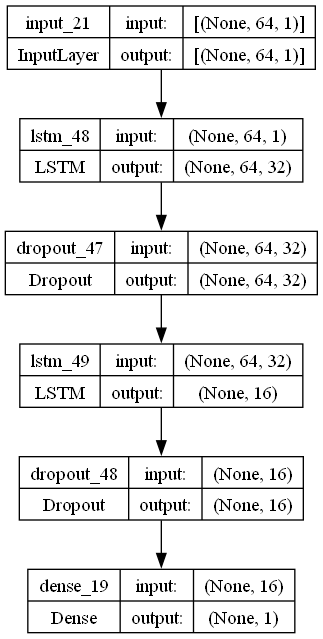

In [11]:
tf.keras.utils.plot_model(timeseries_model, to_file='model_architecture.png', show_shapes=True)

In [13]:
with open('sequence_length.json', 'r') as f:
    seq_len = json.load(f)["sequence_length"]

In [14]:
df_extrapolate =  df.iloc[-1*seq_len:]

In [15]:
df_extrapolate.shape

(64, 2)

In [16]:
# The dataset ends at Feb 15, so we start predicting from Feb 16
feb = 16
preds = []
predictors = list(df_extrapolate["Close"])
# Scaled_predictors will have shape seq_len * 1
scaled_predictors = minmax_scaler.transform(np.array(predictors).reshape(-1, 1))

while(feb < 29):
    # Convert model input to 1 * seq_len * 1
    pred = timeseries_model.predict(scaled_predictors.reshape(1, scaled_predictors.shape[0], scaled_predictors.shape[1]))
    preds.append(minmax_scaler.inverse_transform(pred)[0][0])
    scaled_predictors = list(scaled_predictors)[1:]
    scaled_predictors.append(pred[0])
    scaled_predictors = np.array(scaled_predictors)
    feb += 1

1/1 [==============================] - 0s 26ms/step


In [17]:
from datetime import datetime

In [18]:
feb16_28 = []
for i in range(16, 29):
    date_str = f'2024-02-{i}'
    date_object = datetime.strptime(date_str, '%Y-%m-%d').date()
    feb16_28.append(date_object)

In [19]:
len(feb16_28), len(preds)

(13, 13)

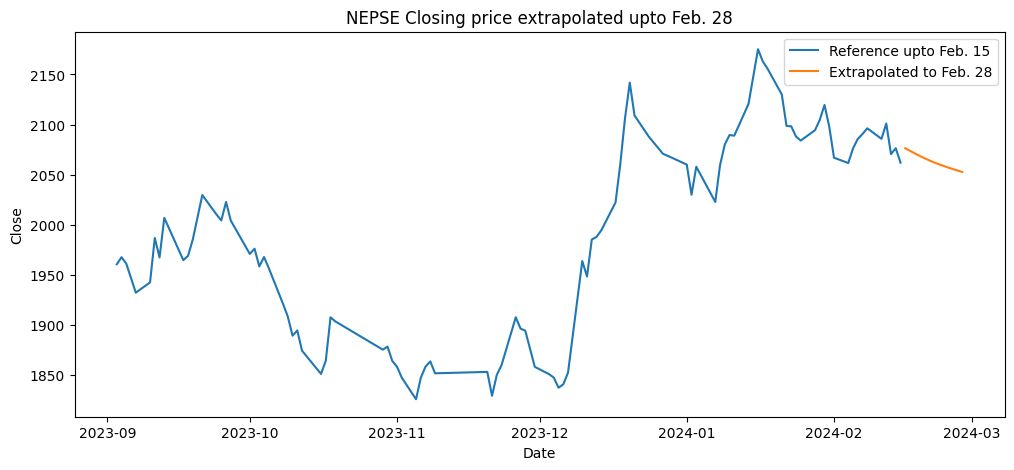

In [20]:
plt.figure(figsize=(12,5))
# plt.xlabel('Date')

ax1 = sns.lineplot(x="Date", y="Close", data=df.iloc[-100:], label="Reference upto Feb. 15")
ax2 = sns.lineplot(x=feb16_28, y=preds, label="Extrapolated to Feb. 28")
plt.title("NEPSE Closing price extrapolated upto Feb. 28")
plt.show()

In [21]:
list(zip(feb16_28, preds))

[(datetime.date(2024, 2, 16), 2076.355),
 (datetime.date(2024, 2, 17), 2073.8684),
 (datetime.date(2024, 2, 18), 2071.3472),
 (datetime.date(2024, 2, 19), 2068.9116),
 (datetime.date(2024, 2, 20), 2066.615),
 (datetime.date(2024, 2, 21), 2064.4756),
 (datetime.date(2024, 2, 22), 2062.489),
 (datetime.date(2024, 2, 23), 2060.6409),
 (datetime.date(2024, 2, 24), 2058.911),
 (datetime.date(2024, 2, 25), 2057.279),
 (datetime.date(2024, 2, 26), 2055.7275),
 (datetime.date(2024, 2, 27), 2054.2405),
 (datetime.date(2024, 2, 28), 2052.8071)]